#### SCCAF clustering for Cai 2020 + 2022 healthy PBMCs

**Objective**: Run SCCAF clustering in separate environment to solve dependency issues

- **Developed by**: Mairi McClean
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- v230316

### Use `SCCAF` to select `leiden` resolution

> What is SCCAF? "Single Cell Clustering Assessment Framework"
>> It is a way to cluster cells based on gene expression; it uses repeat applications of clustering and ML models to generate gene expression profiles - it identifies distinct cell groups and a weighted list of feature genes for each group

> What is the architecture/algorithm of the model?
>> ML [logistic regression, random forest, Gaussian process classification, support vector machine and decision tree] and 5-fold CV

### Import modules

In [1]:
import sys
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random


from umap import UMAP
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import SCCAF as sccaf
from SCCAF import SCCAF_assessment, plot_roc


/Users/mairi.mcclean/mambaforge/envs/scanpy_scvi_local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read in adata objects

##### adata object

In [2]:
adata = sc.read_h5ad('/Volumes/LaCie/data_lake/Mairi_example/processed_files/scvi/pre_sccaf/Cai_healthy_scRNA_PBMC_mm2303016_pre_sccaf_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 22049 × 8000
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'object', 'protocol', 'dataset', '_scvi_batch', '_scvi_labels'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'n_cells_by_counts-caiy2022', 'mean_counts-caiy2022', 'pct_dropout_by_counts-caiy2022', 'total_counts-caiy2022', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'individual_colors', 'neighbors', 'sample_colors', 'status_colors', 'study_colors', 'tis

In [3]:
adata.obs

,study,individual,sample,tissue,donor,age,gender,status,data_type,centre,...,percent_chrY,XIST-counts,S_score,G2M_score,predicted_doublets,object,protocol,dataset,_scvi_batch,_scvi_labels
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGGCGT-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,0.138408,0.0,-0.274516,-0.168208,0.0,NaN,NaN,caiy2020,0,0
AAACCTGAGATGTGTA-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,0.162022,0.0,-0.291798,-0.157942,0.0,NaN,NaN,caiy2020,0,0
AAACCTGAGCAACGGT-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,0.174764,0.0,-0.315739,0.098983,0.0,NaN,NaN,caiy2020,0,0
AAACCTGAGCCATCGC-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,0.015828,0.0,0.037617,0.046320,0.0,NaN,NaN,caiy2020,0,0
AAACCTGAGGTGATTA-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,0.109589,0.0,0.001693,-0.202441,0.0,NaN,NaN,caiy2020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCGCGGTT-H1-caiy2020,CaiY_2021,SAMN14048019,PBMC_HC_1,PBMC,SAMN14048019,26,male,Healthy,scRNAseq,Shenzhen University,...,0.110193,0.0,-0.165353,-0.250572,0.0,NaN,NaN,caiy2020,0,0
TTTGTCAGTCGCTTCT-H1-caiy2020,CaiY_2021,SAMN14048019,PBMC_HC_1,PBMC,SAMN14048019,26,male,Healthy,scRNAseq,Shenzhen University,...,0.043309,0.0,-0.177318,-0.173327,0.0,NaN,NaN,caiy2020,0,0
TTTGTCAGTTCGAATC-H1-caiy2020,CaiY_2021,SAMN14048019,PBMC_HC_1,PBMC,SAMN14048019,26,male,Healthy,scRNAseq,Shenzhen University,...,0.040551,0.0,-0.235875,-0.013744,0.0,NaN,NaN,caiy2020,0,0


#### caiy_healthy object

In [4]:
caiy_healthy = sc.read_h5ad('/Volumes/LaCie/data_lake/Mairi_example/processed_files/scvi/pre_sccaf/Cai_healthy_scRNA_PBMC_mm2303016_pre_sccaf_caiy_healthy.h5ad')
caiy_healthy

AnnData object with n_obs × n_vars = 22049 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'object', 'protocol', 'dataset'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'n_cells_by_counts-caiy2022', 'mean_counts-caiy2022', 'pct_dropout_by_counts-caiy2022', 'total_counts-caiy2022'
    layers: 'counts', 'sqrt_norm'

#### Clustering

In [5]:
sc.tl.leiden(adata, resolution = 0.7, random_state = 1786)

In [6]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)


Mean CV accuracy: 0.4308
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.4368


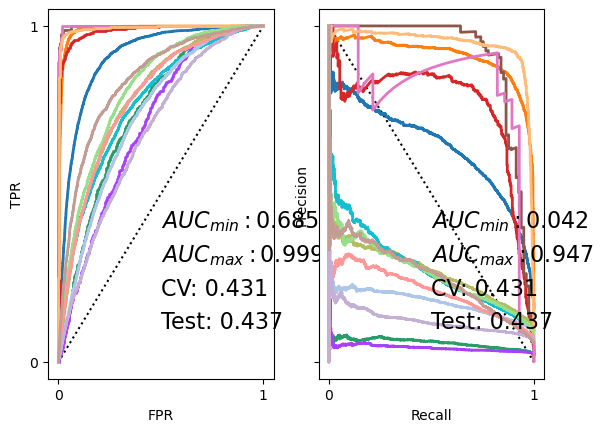

In [7]:
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.show()

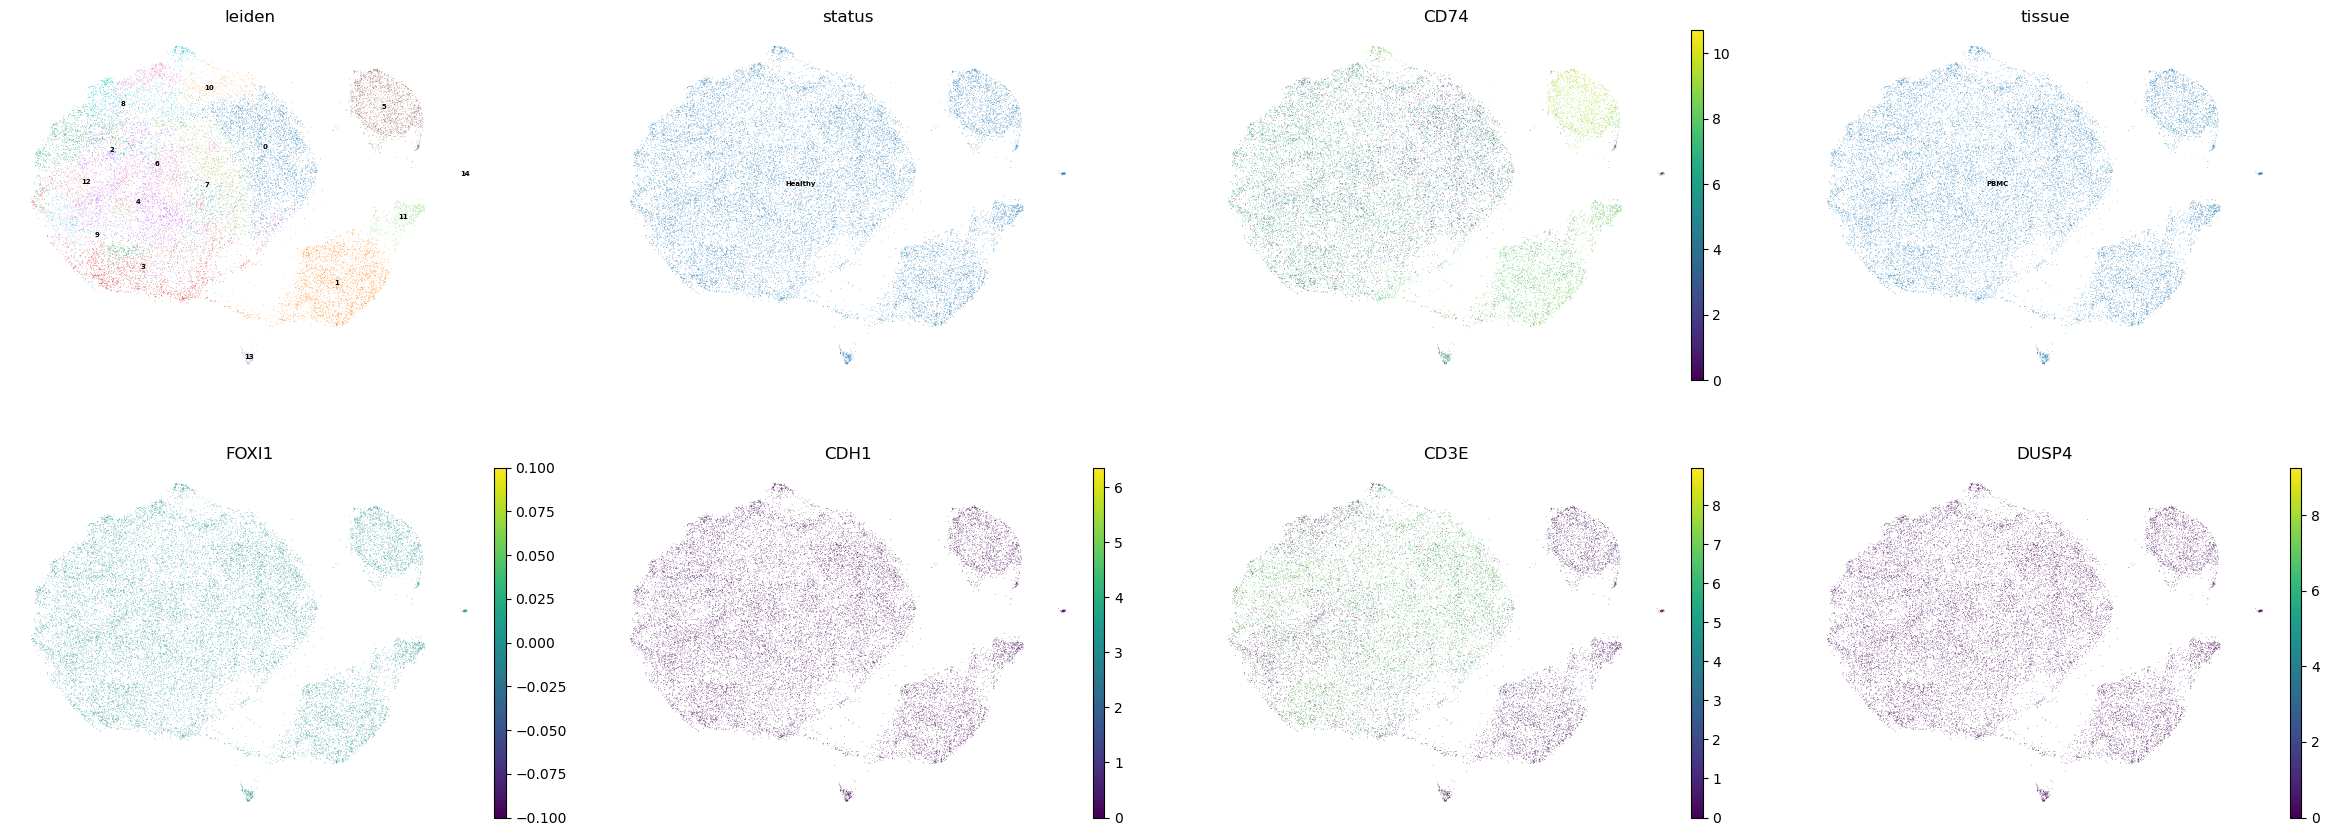

In [8]:
sc.pl.umap(adata, frameon = False, color = ['leiden', 'status', 'CD74', 'tissue', 'FOXI1', 'CDH1', 'CD3E', 'DUSP4'], size = 0.8, legend_fontsize = 5, legend_loc = 'on data')

In [9]:
# sc.pl.umap(adata, frameon = False, color = ['leiden', 'status', 'tissue', 'ADH7', 'CDH1', 'CD74', 'CD3E', 'MUC20', 'DUSP4', 'FOXJ1', 'MUC1', 'FOXI1'], size = 1, legend_fontsize = 5)

### Export clustered object

In [10]:
adata
caiy_healthy

AnnData object with n_obs × n_vars = 22049 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'object', 'protocol', 'dataset'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'n_cells_by_counts-caiy2022', 'mean_counts-caiy2022', 'pct_dropout_by_counts-caiy2022', 'total_counts-caiy2022'
    layers: 'counts', 'sqrt_norm'

In [11]:
# Making a hybrid anndata object using sections from both original anndata object and the cai_tb_gex object
adata_export = anndata.AnnData(X = caiy_healthy.X, var = caiy_healthy.var, obs = adata.obs, uns = adata.uns, obsm = adata.obsm, layers = caiy_healthy.layers, obsp = adata.obsp)
adata_export

AnnData object with n_obs × n_vars = 22049 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'object', 'protocol', 'dataset', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'n_cells_by_counts-caiy2022', 'mean_counts-caiy2022', 'pct_dropout_by_counts-caiy2022', 'total_counts-caiy2022'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'individual_colors', 'neighbors', 'sample_colors', 'status_colors', 'study_colors', 'tissue_colors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorica

In [12]:
adata_export.write('/Volumes/Lacie/data_lake/Mairi_example/processed_files/scvi/post_sccaf/CaiY_healthy_scRNA_PBMC_mm230316_scVI-clustered.raw.h5ad')
